<a href="https://colab.research.google.com/github/aniketmaurya/GANs-PyTorch-models/blob/main/DC-GAN/dc_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DC-GAN

**Paper: Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks**

**Link: https://arxiv.org/abs/1511.06434**

**Authors: Alec Radford, Luke Metz, Soumith Chintala**

## Abstract
In recent years, supervised learning with convolutional networks (CNNs) has seen huge adoption in computer vision applications. Comparatively, unsupervised learning with CNNs has received less attention. In this work we hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning. We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning. Training on various image datasets, we show convincing evidence that our deep convolutional adversarial pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Additionally, we use the learned features for novel tasks - demonstrating their applicability as general image representations.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
    
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

torch.manual_seed(0)

In [20]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Network

GANs are made up of two entities - Generator and Discriminator.

## Generator
Generator learns the data distribution and creates fake images.

In [2]:
class Generator(nn.Module):
    
    def __init__(self, in_channels=3, z_dim=100):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            self.create_upblock(z_dim, 1024, kernel_size=4, stride=1, padding=0),
            self.create_upblock(1024, 512, kernel_size=4, stride=2, padding=1),
            self.create_upblock(512, 256, kernel_size=4, stride=2, padding=1),
            self.create_upblock(256, 128, kernel_size=4, stride=2, padding=1),
            self.create_upblock(128, 3, kernel_size=4, stride=2, padding=1, final_layer=True),
        )
    
    def create_upblock(self, in_channels, out_channels, kernel_size=5, stride=2, padding=1, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Tanh()
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    
    def forward(self, noise):
        """
        noise: random vector of shape=(N, 100, 1, 1)
        """
        assert len(noise.shape)==4, 'random vector of shape=(N, 100, 1, 1)'
        
        return self.gen(noise)

# Discriminator

In [3]:
class Discriminator(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4, stride=1),
            self.make_disc_block(hidden_dim*4, hidden_dim * 4, stride=2),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

Initialise Generator and Discriminator

In [13]:
# Configurations are from DCGAN paper
z_dim = 100
batch_size = 128
lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

In [14]:
criterion = nn.BCEWithLogitsLoss()
display_step = 500

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


gen = Generator().to(device)
disc = Discriminator().to(device)


gen_optimizer = Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
disc_optimizer = Adam(disc.parameters(), lr, betas=(beta_1, beta_2))


gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [22]:
# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform=transforms.Compose([
                            transforms.Resize(64),
                            transforms.CenterCrop(64),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])

dataloader = DataLoader(
    datasets.CelebA('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Files already downloaded and verified


Step 500: Generator loss: 3.2731681108176716, discriminator loss: 0.375973255753517


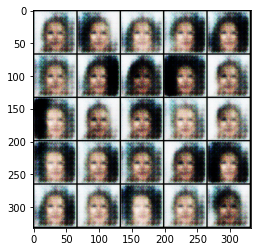

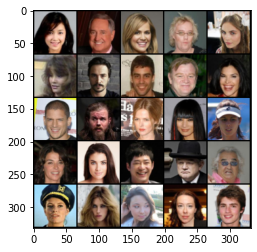

Step 1000: Generator loss: 2.1668175997734047, discriminator loss: 0.48582258865237254


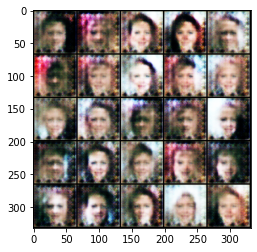

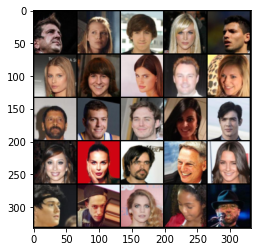

Step 1500: Generator loss: 2.3206881021261236, discriminator loss: 0.43772944599389996


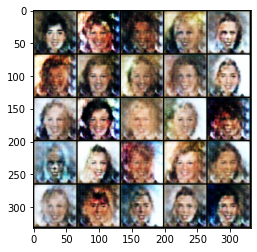

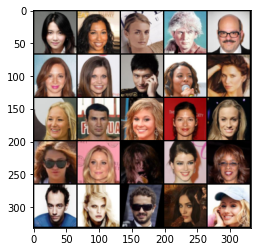

Step 2000: Generator loss: 2.2721628928184514, discriminator loss: 0.47197228449583023


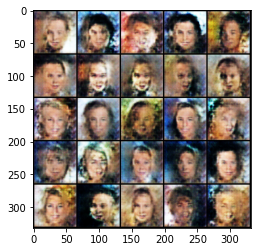

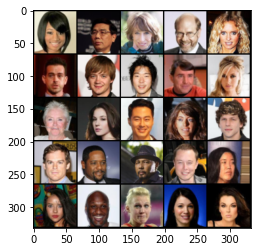

Step 2500: Generator loss: 2.0259362198114372, discriminator loss: 0.48698026674985856


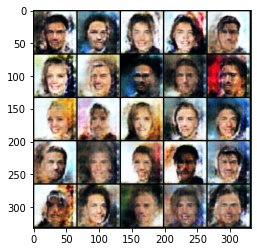

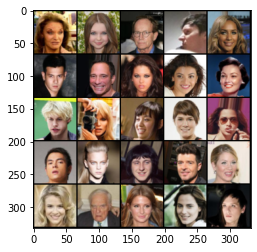

Step 3000: Generator loss: 1.9427470376491542, discriminator loss: 0.47478876829147354


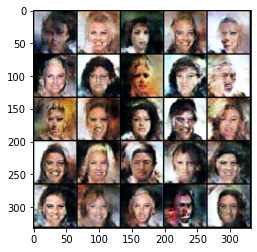

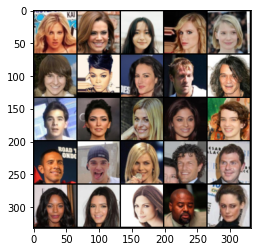

Step 3500: Generator loss: 1.7696209927797313, discriminator loss: 0.49330168616771664


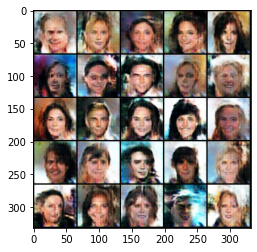

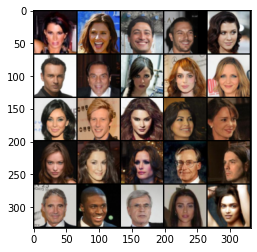

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        real = real.to(device)

        cur_batch_size = len(real)

        ## Update discriminator ##
        disc_optimizer.zero_grad()

        noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)

        disc_fake_logits = disc(fake.detach())
        disc_real_logits = disc(real)

        disc_fake_loss = criterion(disc_fake_logits, torch.zeros_like(disc_fake_logits))
        disc_real_loss = criterion(disc_real_logits, torch.ones_like(disc_real_logits))
        disc_avg_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_avg_loss.item() / display_step
        # Update gradients
        disc_avg_loss.backward(retain_graph=True)
        # Update optimizer
        disc_optimizer.step()

        ## Update generator ##
        gen_optimizer.zero_grad()

        noise2 = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_2 = gen(noise2)
        disc_fake_logits = disc(fake_2)
        
        gen_loss = criterion(disc_fake_logits, torch.ones_like(disc_fake_logits))
        gen_loss.backward()
        gen_optimizer.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
